# LuFi Visualization Deep Net

I show three visualizations for the deep net on BhNo. Maybe we can us this for a final decision what visualizations to use? Please let me know which ones you find worthwhile including in a paper and which modifications are needed.

Dataset is common average referenced, using only C-sensors. I can try repeat with all sensors, however:
* Images will become even larger obviously
* I either spend a lot of time fiddling around avoiding memory problems for the envelope correlation or only use a part of the train dataset. I have tried using only the first 200 trials and the visualization still looked ok, slightly more noisy.


## Weights

* quite noisy

In [28]:
from braindecode.analysis.plot_util import plot_head_signals_tight
from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   get_bci_competition_iv_2a_sensors)
from braindecode.analysis.movie_util import movie_head_signals_tight

sensor_names = exp.dataset.sets[0].sensor_names
sensor_map = tight_C_positions
fig = plot_head_signals_tight(temp_spat_weights[0], sensor_names, 
                              sensor_map=sensor_map,
                        figsize=(14,10))
movie_head_signals_tight(fig, temp_spat_weights, "Weights")

### FFT/Amplitudes

* Focus on lower frequencies
* Note we only have bins 0,25,50,75,100,125 Hz! Because weights are only 10 samples long

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


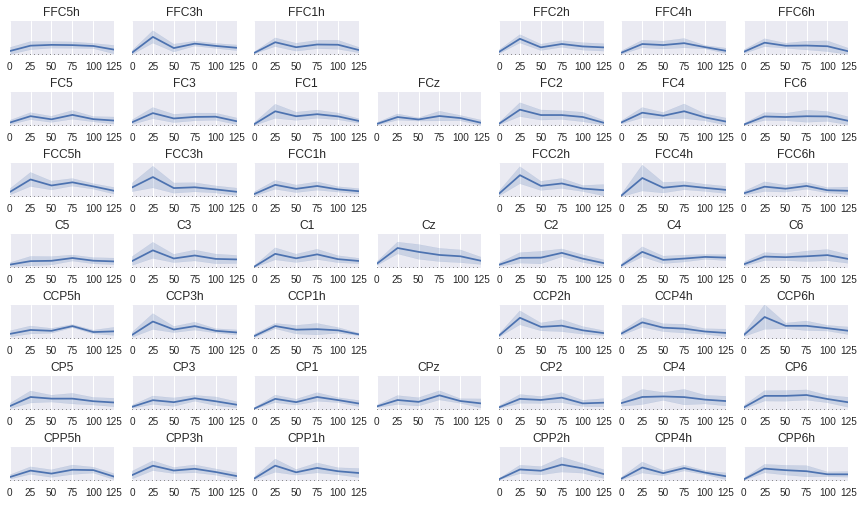

In [33]:
from braindecode.analysis.util import amplitudes_and_freqs
from braindecode.analysis.util import median_absolute_deviation
from braindecode.analysis.plot_util import plot_head_signals_tight_with_tube

bps, freqs = amplitudes_and_freqs(temp_spat_weights, sampling_rate=250.0,axis=2)

fig = plot_head_signals_tight_with_tube(np.median(bps, axis=0),
                                        median_absolute_deviation(bps, axis=0),
                              sensor_names, sensor_map=sensor_map)
plt.xticks(range(bps.shape[2]), np.round(freqs).astype(np.int32))

plt.tight_layout()
None

### Comparison to trialwise trained model

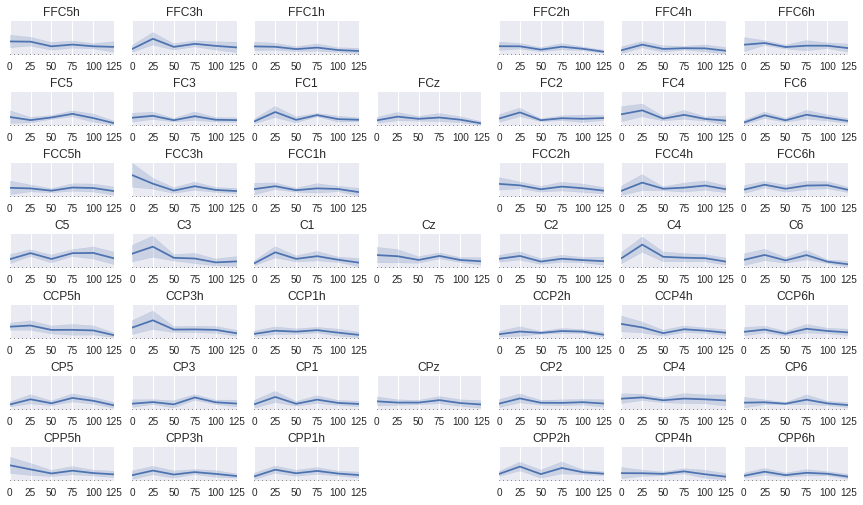

In [34]:
from braindecode.analysis.util import amplitudes_and_freqs
from braindecode.analysis.util import median_absolute_deviation
from braindecode.analysis.plot_util import plot_head_signals_tight_with_tube

bps, freqs = amplitudes_and_freqs(epo_temp_spat_weights, sampling_rate=250.0,axis=2)

fig = plot_head_signals_tight_with_tube(np.median(bps, axis=0),
                                        median_absolute_deviation(bps, axis=0),
                              sensor_names, sensor_map=sensor_map)
plt.xticks(range(bps.shape[2]), np.round(freqs).astype(np.int32))

plt.tight_layout()
None

## Heatmaps

### Median over all trials

* We see different relevances for different sensors, larger relevances on C3 and C4 for example
* We see very small deviation
* We see a decrease shortly after the start of the trial
* Note decreases at end and start are influenced by border effects with valid convolution (no padding)
* Note heatmaps are from trialwise trained model due to simplicity of computation
* Note I have changed heatmap computation from original paper, a) using an adaptive rule that computes minimum/maximum input for each layer for the current trial b) using absolute values to backprop relevance through pooling (since we are not using relus we can have negative values as pooling inputs, which breaks the original algorithm)
* I still have to take care of bias :))

(Tube around line is median absolute deviation)

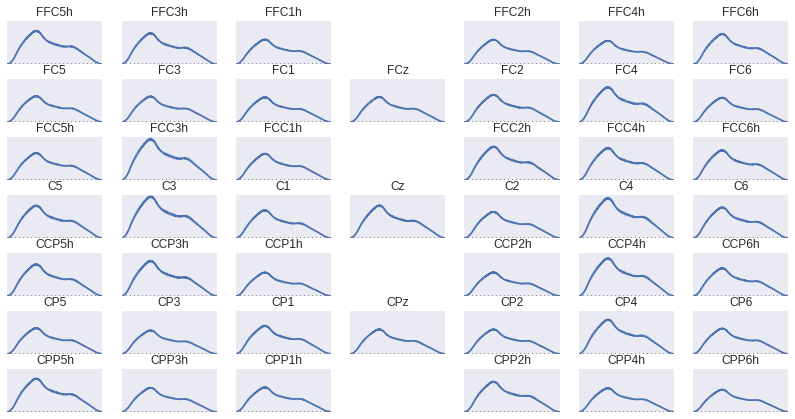

In [35]:
from braindecode.analysis.plot_util import plot_heatmap
plot_head_signals_tight_with_tube(median_train_relevance, mad_train_relevance,
    sensor_names,
    sensor_map=sensor_map,
    figsize=(14,7))
None

### Median per class

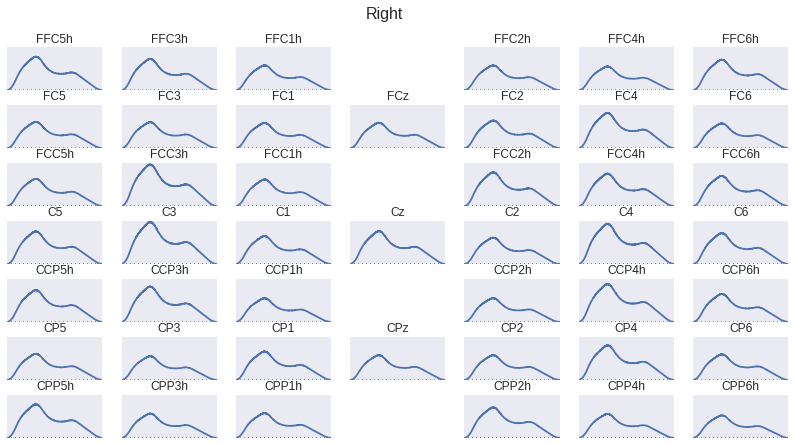

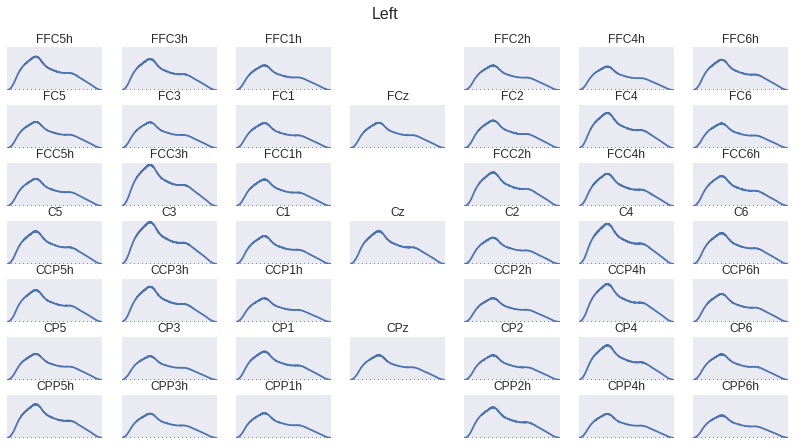

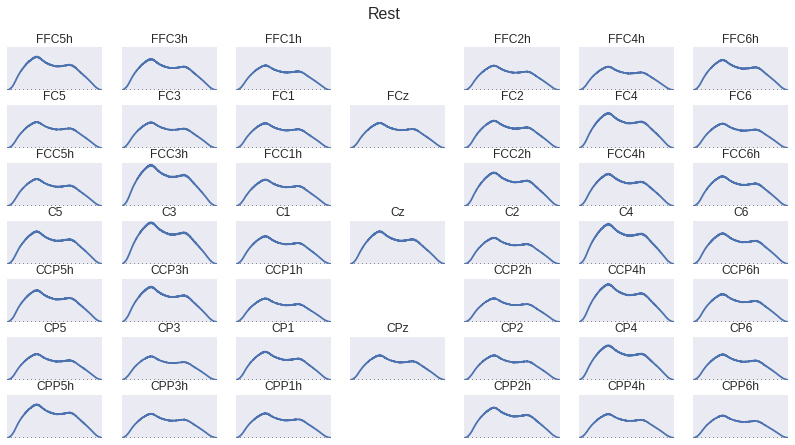

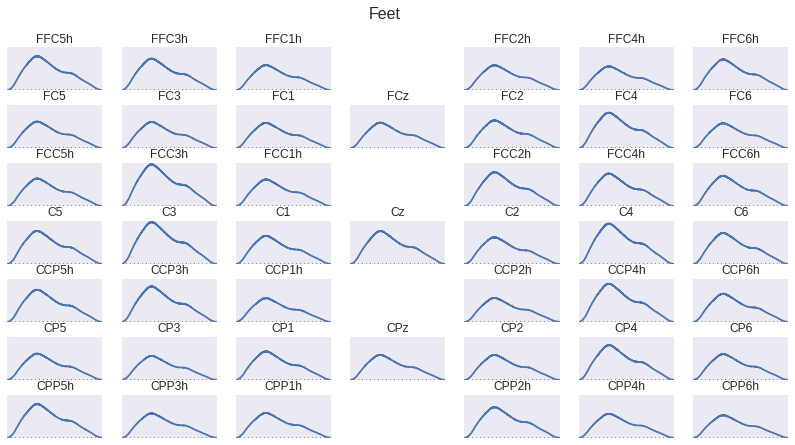

In [36]:
from braindecode.analysis.plot_util import plot_heatmap

class_names = ['Right', 'Left', 'Rest', 'Feet']
for i_class in range(4):
    class_relevances = train_relevances[epo_ys[:, i_class] == 1]
    fig = plot_head_signals_tight_with_tube(np.median(class_relevances, axis=0), 
        median_absolute_deviation(class_relevances, axis=0),
        sensor_names,
        sensor_map=sensor_map,
        figsize=(14,7))
    fig.suptitle(class_names[i_class], fontsize=16)
    #plt.tight_layout()
None

### Correct vs Incorrect Trial

I show two trials for the left hand, one correctly predicted, one erroneously predicted as right hand.

* Heatmap on entire trial is not very easy to interpret
* C3/C4 difficult to see, but maybe amplitude changes are plausible(?)

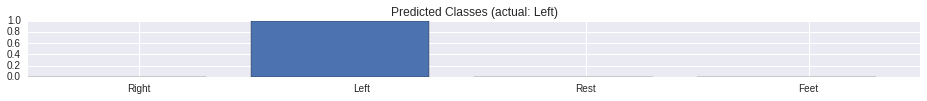

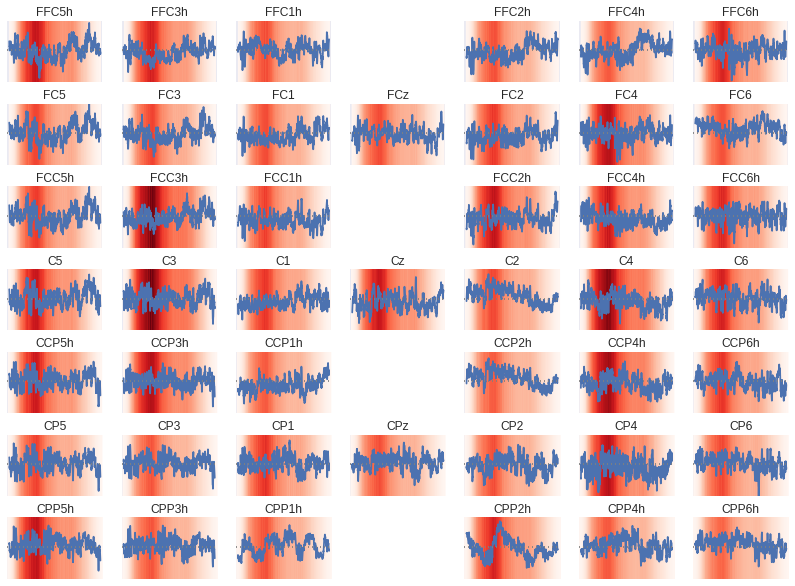

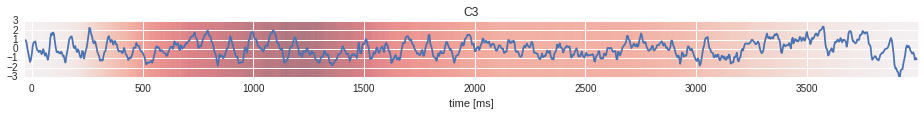

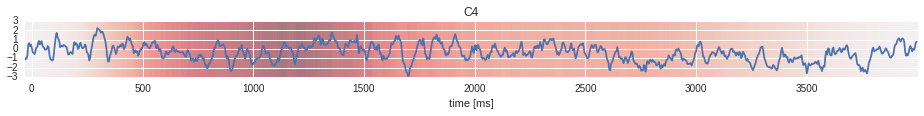

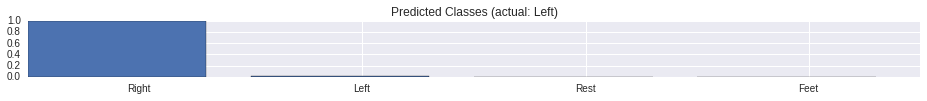

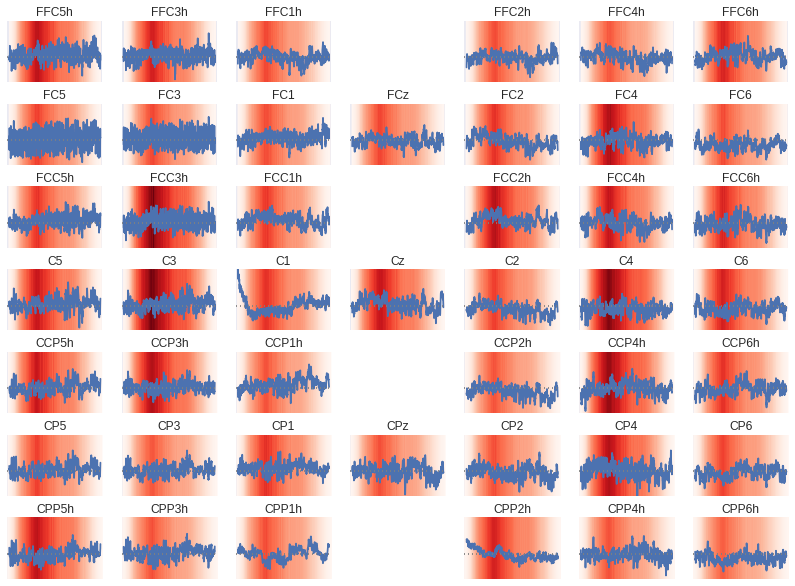

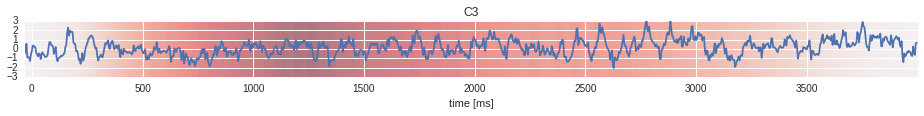

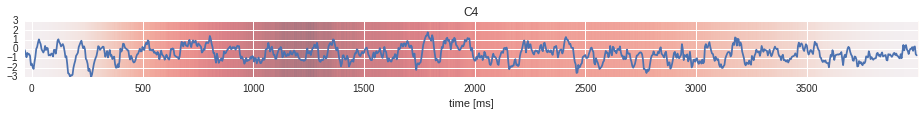

In [42]:
i_both_trials = [correct_trial, incorrect_trial]
sensors_to_compare = ['C3', 'C4']
for i_trial in i_both_trials:
    plt.figure()
    plt.bar(np.arange(4), test_preds[i_trial])
    plt.xticks(np.arange(0.5,4,1), class_names)
    plt.title("Predicted Classes (actual: {:s})".format(class_names[epo_test_set.y[i_trial]]))

    plot_heatmap(epo_test_topo[i_trial], 
                 test_relevances[i_trial],sensor_names, sensor_map)
    for s_name in sensors_to_compare:
        plt.figure()
        i_sensor = sensor_names.tolist().index(s_name)
        plt.plot(epo_test_topo[i_trial, i_sensor].squeeze())
        ax = plt.gca()
        ax.set_xlim(0,epo_test_topo.shape[2])
        ax.set_ylim(-3,3)
        plotlim = [ax.get_xlim()[0] - 0.5, ax.get_xlim()[1] + 0.5] + list(ax.get_ylim())
        ax.imshow(test_relevances[i_trial, i_sensor].T, cmap=cm.Reds, interpolation='nearest',
                    extent=plotlim, aspect='auto',
                         vmin=np.min(test_relevances[i_trial, i_sensor]), 
                                     vmax=np.max(test_relevances[i_trial, i_sensor]),
                 alpha=0.5)
        plt.title(s_name)
        plt.xticks(range(8,1008,125), range(0,4000,500))
        plt.xlabel('time [ms]')

## Envelope Correlation

Correlation with envelope in different frequencies. Now much more finegrained frequency resolution.

* Interesting topology visible
* No high frequencies used
* Red is positive correlation, blue is negative correlation, grey is no correlation (colormap capped between -0.5 and 0.5 for better visibility)
* Note resolution=y-axis is finer in lower and coarser in higher frequencies

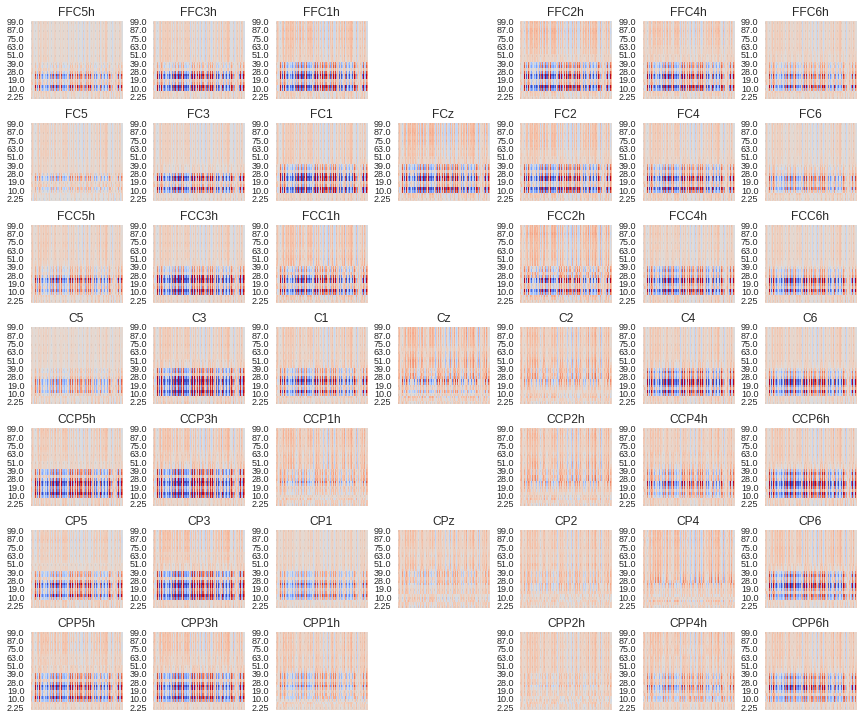

In [131]:
from braindecode.analysis.plot_util import plot_chan_matrices
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

### Lower frequencies

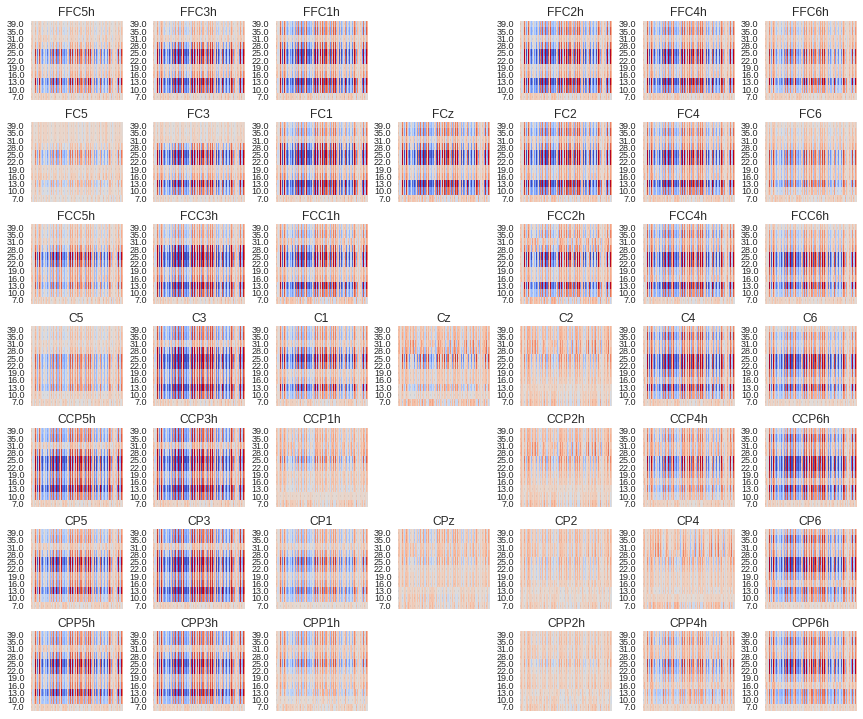

In [132]:
from braindecode.analysis.plot_util import plot_chan_matrices
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1)[:,:,2:13],
                        sensor_names, sensor_map=tight_C_positions,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands[2:13])) + 0.5, np.mean(filterbands, axis=1)[2:13])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

### Single sensor

High frequencies not really visible

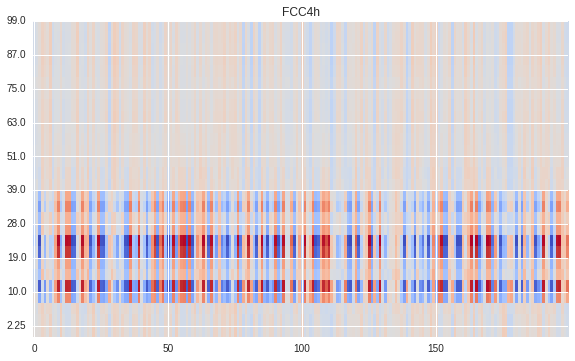

In [133]:
s_name = 'FCC4h'
i_sensor = sensor_names.tolist().index(s_name)
plt.figure(figsize=(8,5))
plt.imshow(topo_corrs[17], cmap=cm.coolwarm, interpolation='nearest', origin='lower left',
          aspect='auto')
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])
plt.title(s_name)
for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

### Comparison to random model

Same visualization, but using an untrained network. I scaled (up) random correlations to have same standard deviation as those from trained model. 

* No structure visible at all

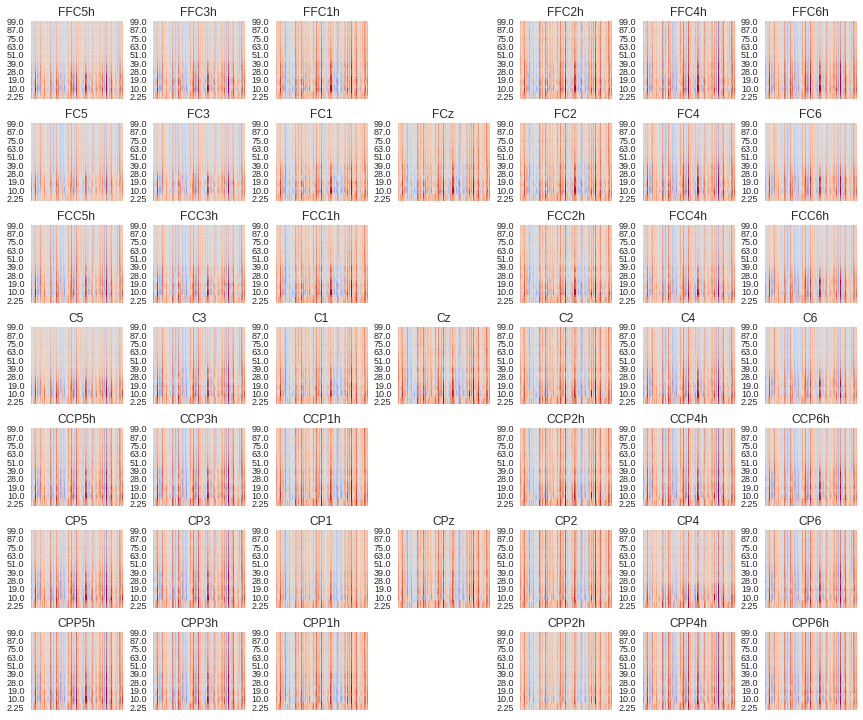

In [139]:
from braindecode.analysis.plot_util import plot_chan_matrices
fig = plot_chan_matrices(rand_topo_corrs_scaled.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

# Code

In [2]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np

## Load

In [8]:
from braindecode.experiments.experiment_runner import create_experiment
from braindecode.experiments.load import load_exp_and_model

#basename = 'data/models/paper/bci-competition/cnt/deep4/147'
basename = 'data/models/paper/ours/cnt/deep4/car/9'
exp, model = load_exp_and_model(basename)

assert 'LuFi' in exp.dataset.train_set.signal_processor.set_loader.filename

INFO:braindecode.experiments.experiment_runner:Setting n_sample preds automatically to 479
INFO:braindecode.experiments.experiment_runner:Input window length is 522


In [9]:
exp.dataset.load()

INFO:braindecode.datasets.combined:Load Training Set...
INFO:braindecode.datasets.combined:Load Test Set...
INFO:braindecode.mywyrm.clean:Clean Training Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     813
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Clean Test Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     160
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Create Cleaned Cnt Sets...
INFO:braindecode.datasets.combined:Create sets from cleaned cnt...
INFO:braindecode.datasets.cnt_signal_mat

In [45]:
from braindecode.veganlasagne.layers import print_layers

In [13]:
from braindecode.analysis.combine_weights import combine_temporal_spatial_weights
epo_basename = 'data/models/paper/ours/epo/deep4/car/9'
epo_exp, epo_model = load_exp_and_model(epo_basename)
assert 'LuFi' in epo_exp.dataset.train_set.signal_processor.set_loader.filename

In [14]:
epo_exp.dataset.load()

INFO:braindecode.datasets.combined:Load Training Set...
INFO:braindecode.datasets.combined:Load Test Set...
INFO:braindecode.mywyrm.clean:Clean Training Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     813
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Clean Test Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     160
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Create Cleaned Cnt Sets...
INFO:braindecode.datasets.combined:Create sets from cleaned cnt...
INFO:braindecode.datasets.raw:Cleaning s

## Weights

In [15]:
all_layers = lasagne.layers.get_all_layers(model)

from braindecode.analysis.combine_weights import combine_temporal_spatial_weights

temp_weights = all_layers[3].W.get_value()
spat_weights = all_layers[4].W.get_value()
temp_spat_weights = combine_temporal_spatial_weights(temp_weights, spat_weights)

epo_layers = lasagne.layers.get_all_layers(epo_model)
epo_temp_spat_weights = combine_temporal_spatial_weights(epo_layers[3].W.get_value(), 
                                                         epo_layers[4].W.get_value())

## Heatmaps

In [16]:
from braindecode.analysis.heatmap import create_heatmap_fn
from braindecode.veganlasagne.layers import create_pred_fn
from braindecode.analysis.heatmap import compute_all_epo_relevances
epo_train_set = epo_exp.dataset.sets[0]
epo_train_topo = epo_train_set.get_topological_view()

epo_test_set = epo_exp.dataset.sets[1]
epo_test_topo = epo_test_set.get_topological_view()
min_in = min(np.min(epo_train_topo), np.min(epo_test_topo))
max_in = max(np.max(epo_train_topo), np.max(epo_test_topo))

epo_ys = sklearn.preprocessing.OneHotEncoder(4, 
         sparse=False).fit_transform(epo_train_set.y[:,np.newaxis])



heatmap_fn = create_heatmap_fn(epo_layers,rules=['z_b', 'adapt_z_b'], return_all=False,
                              min_in=min_in,
                              max_in=max_in)

epo_pred_fn = create_pred_fn(epo_model)

In [17]:
from braindecode.analysis.util import median_absolute_deviation

train_relevances = compute_all_epo_relevances(epo_train_set, epo_pred_fn, heatmap_fn, n_classes=4)

median_train_relevance = np.median(train_relevances, axis=0).squeeze()
mad_train_relevance = median_absolute_deviation(train_relevances, axis=0).squeeze()

In [18]:

epo_test_ys = sklearn.preprocessing.OneHotEncoder(4, 
         sparse=False).fit_transform(epo_test_set.y[:,np.newaxis])

In [19]:
test_relevances = compute_all_epo_relevances(epo_test_set, epo_pred_fn, heatmap_fn, n_classes=4)
median_test_relevance = np.median(test_relevances, axis=0).squeeze()
mad_test_relevance = median_absolute_deviation(test_relevances, axis=0).squeeze()

In [20]:
test_preds = epo_pred_fn(epo_test_set.get_topological_view())

In [21]:
prob_correct = np.array([p[i_label] for p, i_label in zip(test_preds, epo_test_set.y)])
i_trial_by_correctness = np.argsort(prob_correct)

In [37]:
print epo_test_set.y[i_trial_by_correctness] #2 und -2?

[3 2 1 2 2 1 1 2 3 2 3 1 1 2 2 2 2 2 1 0 1 0 0 2 0 1 0 0 0 1 2 0 1 2 2 0 2
 1 2 3 1 0 2 0 1 2 3 0 3 1 2 1 3 0 2 0 2 0 0 1 1 1 2 3 0 1 3 1 1 2 3 2 3 3
 3 1 2 2 1 0 2 2 1 0 2 3 1 1 0 0 1 3 2 3 0 0 1 3 1 2 3 0 0 2 0 2 3 1 0 0 0
 0 3 3 3 0 0 0 3 0 1 0 2 1 2 0 2 3 1 3 1 2 1 1 0 3 3 1 0 3 0 2 2 2 3 3 3 0
 3 3 3 3 3 3 1 3 1 3 1 3]


In [38]:
print test_preds.argmax(axis=1)[i_trial_by_correctness]

[2 3 0 3 1 0 0 0 2 3 2 1 1 2 2 2 2 2 1 0 1 0 0 2 0 1 0 0 0 1 2 0 1 2 2 0 2
 1 2 3 1 0 2 0 1 2 3 0 3 1 2 1 3 0 2 0 2 0 0 1 1 1 2 3 0 1 3 1 1 2 3 2 3 3
 3 1 2 2 1 0 2 2 1 0 2 3 1 1 0 0 1 3 2 3 0 0 1 3 1 2 3 0 0 2 0 2 3 1 0 0 0
 0 3 3 3 0 0 0 3 0 1 0 2 1 2 0 2 3 1 3 1 2 1 1 0 3 3 1 0 3 0 2 2 2 3 3 3 0
 3 3 3 3 3 3 1 3 1 3 1 3]


In [40]:
incorrect_trial = i_trial_by_correctness[2]
correct_trial = i_trial_by_correctness[-2] # correct left hand trial

## Envelope

In [23]:
from braindecode.veganlasagne.layers import print_layers
print_layers(model)
i_layer = 26

 0 InputLayer                [None, 45, 1000, 1]
 1 DimshuffleLayer           (None, 1, 1000, 45)
 2 DropoutLayer              (None, 1, 1000, 45)
 3 Conv2DLayer               (None, 25, 991, 45)
 4 Conv2DAllColsLayer        (None, 25, 991, 1)
 5 BatchNormLayer            (None, 25, 991, 1)
 6 Pool2DLayer               (None, 25, 989, 1)
 7 StrideReshapeLayer        (None, 25, 330, 1)
 8 NonlinearityLayer         (None, 25, 330, 1)
 9 DropoutLayer              (None, 25, 330, 1)
10 Conv2DLayer               (None, 50, 321, 1)
11 BatchNormLayer            (None, 50, 321, 1)
12 Pool2DLayer               (None, 50, 319, 1)
13 StrideReshapeLayer        (None, 50, 107, 1)
14 NonlinearityLayer         (None, 50, 107, 1)
15 DropoutLayer              (None, 50, 107, 1)
16 Conv2DLayer               (None, 100, 98, 1)
17 BatchNormLayer            (None, 100, 98, 1)
18 Pool2DLayer               (None, 100, 96, 1)
19 StrideReshapeLayer        (None, 100, 32, 1)
20 NonlinearityLayer         (None, 

In [27]:
ls data/models/paper/ours/cnt/deep4/car/*.env.npy

data/models/paper/ours/cnt/deep4/car/10.env.npy
data/models/paper/ours/cnt/deep4/car/1.env.npy
data/models/paper/ours/cnt/deep4/car/2.env.npy
data/models/paper/ours/cnt/deep4/car/3.env.npy


In [43]:
from braindecode.analysis.envelopes import load_trial_env
train_set = exp.dataset_provider.get_train_merged_valid_test(exp.dataset)['train']
trial_env = load_trial_env(basename, model, i_layer, train_set, n_inputs_per_trial=2)

INFO:braindecode.analysis.envelopes:Loading envelope...
INFO:braindecode.analysis.envelopes:Transforming to trial envelope...
INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...


In [44]:
from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


In [134]:
from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

In [135]:
from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
filterbands = np.load(basename + '.filt_bands.npy')


In [136]:
from braindecode.veganlasagne.layer_util import compute_trial_acts
rand_trial_acts = compute_trial_acts(exp.final_layer, i_layer, exp.iterator, train_set)

INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


In [137]:
rand_topo_corrs = compute_topo_corrs(trial_env, rand_trial_acts)

In [138]:
rand_topo_corrs_scaled = rand_topo_corrs * np.std(topo_corrs) / np.std(rand_topo_corrs)